## Optical Forces

This tutorial demonstrates Meep's ability to compute classical forces via the [Maxwell stress tensor](https://en.wikipedia.org/wiki/Maxwell_stress_tensor) (MST). The geometry consists of two identical, parallel, silicon waveguides with square cross section in vacuum. A schematic of the geometry is shown below. Due to the parallel orientation of the waveguides, the two modes can be chosen to be either symmetric or anti-symmetric with respect to an $x$ mirror-symmetry plane between them. As the two waveguides are brought closer and closer together, their modes increasingly couple and give rise to a gradient force that is *transverse* to the waveguide axis (i.e., in the $x$ direction). This is different from [radiation pressure](https://en.wikipedia.org/wiki/Radiation_pressure) which involves momentum exchange between photons and is *longitudinal* in nature. An interesting phenomena that occurs for this coupled system is that the force can be tuned to be either attractive or repulsive depending on the relative phase of the modes. This tutorial will demonstrate this effect.

![](https://meep.readthedocs.io/en/latest/images/Waveguide_forces.png)

The gradient force on each waveguide arising from the evanescent coupling of the two waveguide modes can be computed analytically:

$$F=-\frac{1}{\omega}\frac{d\omega}{ds}\Bigg\vert_\vec{k}U,$$

where $ω$ is the mode frequency of the coupled-waveguide system, $s$ is the separation distance between the parallel waveguides, $k$ is the conserved wave vector and $U$ is the total energy of the electromagnetic fields. By convention, negative and positive values correspond to attractive and repulsive forces, respectively. For more details, see [Optics Letters, Vol. 30, pp. 3042-4, 2005](https://www.osapublishing.org/ol/abstract.cfm?uri=ol-30-22-3042). This expression has been shown to be mathematically equivalent to the MST in [Optics Express, Vol. 17, pp. 18116-35, 2009](http://www.opticsinfobase.org/oe/abstract.cfm?URI=oe-17-20-18116). We will verify this result in this tutorial. Note: in this particular example, only the fundamental `ODD_Y` mode shows the bidirectional force.

It is convenient to normalize the force in order to work with dimensionless quantities. Since the total power transmitted through the waveguide is $P=v_gU/L$ where $v_g$ is the group velocity, $L$ is the waveguide length, and $U$ is defined as before, we focus instead on the force per unit length per unit power $(F/L)(ac/P)$ where $a$ is the waveguide width and $c$ is the speed of light. This dimensionless quantity enables us to compute both the flux and the force in a single simulation.

The gradient force can be computed using two different methods: (1) using MPB, compute the frequency and group velocity for a given mode over a range of separation distances and then use a centered [finite-difference](https://en.wikipedia.org/wiki/Finite_difference) scheme to numerically evaluate the formula from above, and (2) using Meep, directly compute both the gradient force and the power transmitted through the waveguide for the guided mode over the same range of separation distances. This tutorial verifies that (1) and (2) produce equivalent results.

The main component of the script is the function `parallel_waveguide(s,xodd)` which computes the Poynting flux and the force given the waveguide separation distance `s` and parity of the waveguide mode `xodd`. Since the eigenmode frequency is not known apriori, a preliminary [`Harminv`](../Python_User_Interface.md#harminv) run is required using a broadband pulsed source. The propagating mode never decays away and the runtime is therefore chosen arbitrarily as 200 time units after the pulsed sources have turned off. Once we have determined the eigenmode frequency, we then replace the `Source` with [`EigenModeSource`](https://meep.readthedocs.io/en/latest/Python_User_Interface/#eigenmodesource) to compute: (1) the force on each waveguide due to the mode coupling and (2) the power in the mode. The [eigenmode source](https://meep.readthedocs.io/en/latest/Python_Tutorials/Eigenmode_Source/) enables a more efficient mode excitation than simply using a constant-amplitude point/area source.

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

resolution = 30   # pixels/μm
    
Si = mp.Medium(index=3.45)

dpml = 1.0
pml_layers = [mp.PML(dpml)]
    
sx = 5
sy = 3
cell = mp.Vector3(sx+2*dpml,sy+2*dpml,0)

a = 1.0     # waveguide width

k_point = mp.Vector3(z=0.5)

fcen = 0.22
df = 0.06

def parallel_waveguide(s,xodd):
    geometry = [mp.Block(center=mp.Vector3(-0.5*(s+a)),
                         size=mp.Vector3(a,a,mp.inf),
                         material=Si),
                mp.Block(center=mp.Vector3(0.5*(s+a)),
                         size=mp.Vector3(a,a,mp.inf),
                         material=Si)]

    symmetries = [mp.Mirror(mp.X, phase=-1.0 if xodd else 1.0),
                  mp.Mirror(mp.Y, phase=-1.0)]

    sources = [mp.Source(src=mp.GaussianSource(fcen, fwidth=df),
                         component=mp.Ey,
                         center=mp.Vector3(-0.5*(s+a)),
                         size=mp.Vector3(a,a)),
               mp.Source(src=mp.GaussianSource(fcen, fwidth=df),
                         component=mp.Ey,
                         center=mp.Vector3(0.5*(s+a)),
                         size=mp.Vector3(a,a),
                         amplitude=-1.0 if xodd else 1.0)]

    sim = mp.Simulation(resolution=resolution,
                        cell_size=cell,
                        boundary_layers=pml_layers,
                        geometry=geometry,
                        symmetries=symmetries,
                        k_point=k_point,
                        sources=sources)

    h = mp.Harminv(mp.Ey, mp.Vector3(0.5*(s+a)), fcen, df)

    sim.run(mp.after_sources(h), until_after_sources=200)

    f = h.modes[0].freq
    print("freq:, {}, {}".format(s, f))

    sim.reset_meep()

    eig_sources = [mp.EigenModeSource(src=mp.GaussianSource(f, fwidth=df),
                                      size=mp.Vector3(a,a),
                                      center=mp.Vector3(-0.5*(s+a)),
                                      eig_kpoint=k_point,
                                      eig_match_freq=True,
                                      eig_parity=mp.ODD_Y),
                   mp.EigenModeSource(src=mp.GaussianSource(f, fwidth=df),
                                      size=mp.Vector3(a,a),
                                      center=mp.Vector3(0.5*(s+a)),
                                      eig_kpoint=k_point,
                                      eig_match_freq=True,
                                      eig_parity=mp.ODD_Y,
                                      amplitude=-1.0 if xodd else 1.0)]

    sim.change_sources(eig_sources)

    flux_reg = mp.FluxRegion(direction=mp.Z, center=mp.Vector3(), size=mp.Vector3(1.2*(2*a+s),1.2*a))
    wvg_flux = sim.add_flux(f, 0, 1, flux_reg)

    force_reg1 = mp.ForceRegion(mp.Vector3(0.5*s), direction=mp.X, weight=1.0, size=mp.Vector3(y=a))
    force_reg2 = mp.ForceRegion(mp.Vector3(0.5*s+a), direction=mp.X, weight=-1.0, size=mp.Vector3(y=a))
    wvg_force = sim.add_force(f, 0, 1, force_reg1, force_reg2)

    sim.run(until_after_sources=500)

    flux = mp.get_fluxes(wvg_flux)[0]
    force = mp.get_forces(wvg_force)[0]
    
    sim.reset_meep()
    return flux, force

There are two important items to note in `parallel_waveguide`: (1) a single flux surface is used to compute the Poynting flux in $z$ which spans an area slightly larger than both waveguides rather than two separate flux surfaces (one for each waveguide). This is because in the limit of small separation, two flux surfaces overlap whereas the total power through a single flux surface need, by symmetry, only be halved in order to determine the value for just one of the two waveguides. (2) Instead of defining a closed, four-sided "box" surrounding the waveguides, the MST is computed along just two $y$-oriented lines (to obtain the force in the $x$ direction) with different `weight` values to correctly sum the total force. By symmetry, the force in the $y$ direction is zero and need not be computed. Choosing a suitable runtime requires some care. A large runtime is necessary to obtain the steady-state response but this will also lead to large values for the discrete Fourier-transformed fields used to compute both the flux and the MST. Large floating-point numbers may contain [roundoff errors](https://en.wikipedia.org/wiki/Round-off_error).

The simulation is run over the range of separation distances from 0.1 to 1.00 μm in increments of 0.1 μm. The results are compared with those from MPB. This is shown in the figure above. The two methods show good agreement.

In [2]:
s = np.arange(0.1,1.1,0.1)
fluxes_odd = np.zeros(s.size)
forces_odd = np.zeros(s.size)

fluxes_even = np.zeros(s.size)
forces_even = np.zeros(s.size)

for k in range(len(s)):
    fluxes_odd[k], forces_odd[k] = parallel_waveguide(s[k],True)
    fluxes_even[k], forces_even[k] = parallel_waveguide(s[k],False)

-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00360179 s
Working in 3D dimensions.
Computational cell is 7 x 5 x 0.0333333 with resolution 30
     block, center = (-0.55,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0.55,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
time for set_epsilon = 0.0422099 s
-----------
Meep: using complex fields.
Meep progress: 89.8/366.6666717529297 = 24.5% done in 4.0s, 12.3s to go
on time step 5388 (time=89.8), 0.000742406 s/step
Meep progress: 181.51666666666665/366.6666717529297 = 49.5% done in 8.0s, 8.2s to go
on time step 10892 (time=181.533), 0.000726833 s/step
Meep progress: 270.9166666666667/366.6666717529297 = 73

     block, center = (0.6,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
time for set_epsilon = 0.0331678 s
-----------
Meep: using complex fields.
Meep progress: 73.96666666666667/366.6666717529297 = 20.2% done in 4.0s, 15.8s to go
on time step 4438 (time=73.9667), 0.000901337 s/step
Meep progress: 148.65/366.6666717529297 = 40.5% done in 8.0s, 11.7s to go
on time step 8920 (time=148.667), 0.000892644 s/step
Meep progress: 218.96666666666667/366.6666717529297 = 59.7% done in 12.0s, 8.1s to go
on time step 13140 (time=219), 0.000947903 s/step
Meep progress: 291.5/366.6666717529297 = 79.5% done in 16.0s, 4.1s to go
on time step 17490 (time=291.5), 0.000919692 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.2320582072289672, -7.187375062052522e-10, 161434602.49777028, 0.7086613397470293, -0.3801627466619353-0.5980611845810657i, 1.4487929164079128e-13+0.0i

Meep progress: 160.58333333333334/366.6666717529297 = 43.8% done in 8.0s, 10.3s to go
on time step 9635 (time=160.583), 0.000815166 s/step
Meep progress: 241.01666666666665/366.6666717529297 = 65.7% done in 12.0s, 6.3s to go
on time step 14462 (time=241.033), 0.000828869 s/step
Meep progress: 319.76666666666665/366.6666717529297 = 87.2% done in 16.0s, 2.3s to go
on time step 19188 (time=319.8), 0.00084651 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.2304584794221163, 1.0634248187984447e-09, -108356733.52184385, 0.8547952870601584, 0.22921259365443036-0.8234904794170165i, 2.6330486575457057e-13+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.30000000000000004, 0.2304584794221163
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00135112 s
Working in 3D dimensions.
Computational cell is 7 x 5 x 0.0333333 with resolut

Meep progress: 292.1666666666667/366.6666717529297 = 79.7% done in 16.0s, 4.1s to go
on time step 17532 (time=292.2), 0.000884238 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.22933726326384737, 2.79426147240498e-09, -41037187.38004503, 0.9591142558886121, 0.7259793855459205-0.6267807332800953i, 5.574464349569071e-14+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.4, 0.22933726326384737
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.0013938 s
Working in 3D dimensions.
Computational cell is 7 x 5 x 0.0333333 with resolution 30
     block, center = (-0.7,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0.7,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectr

harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.22835035053721117, 4.685319627884293e-09, -24368705.7312166, 1.0451771206496243, 1.0252873926430903-0.2029309636713261i, 2.7856797013746015e-13+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.5, 0.22835035053721117
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00148392 s
Working in 3D dimensions.
Computational cell is 7 x 5 x 0.0333333 with resolution 30
     block, center = (-0.75,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0.75,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
time for set_epsilon = 0.0936301 s
-----------
Meep: using complex fields.
M

Meep progress: 296.05/366.6666717529297 = 80.7% done in 16.0s, 3.8s to go
on time step 17765 (time=296.083), 0.000904528 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.2277481607926663, 6.590783575316441e-09, -17277775.71437942, 1.0971848191249656, 1.089302838353774+0.13127777295755527i, 1.5429683557892107e-13+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.6, 0.2277481607926663
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.0014081 s
Working in 3D dimensions.
Computational cell is 7 x 5 x 0.0333333 with resolution 30
     block, center = (-0.8,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (11.9025,11.9025,11.9025)
     block, center = (0.8,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric consta

Meep progress: 290.9166666666667/366.6666717529297 = 79.3% done in 16.0s, 4.2s to go
on time step 17457 (time=290.95), 0.000925947 s/step
Meep progress: 364.26666666666665/366.6666717529297 = 99.3% done in 20.0s, 0.1s to go
on time step 21858 (time=364.3), 0.000908912 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.227168908860377, 8.795584365758671e-09, -12913804.212074222, 1.1420749012296723, 1.041290755826275+0.46909342550233035i, 1.338451142437783e-13+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.7000000000000001, 0.227168908860377
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00138187 s
Working in 3D dimensions.
Computational cell is 7 x 5 x 0.0333333 with resolution 30
     block, center = (-0.85,0,0)
          size (1,1,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon 

Meep progress: 150.95/366.6666717529297 = 41.2% done in 8.0s, 11.4s to go
on time step 9058 (time=150.967), 0.000848313 s/step
Meep progress: 228.11666666666667/366.6666717529297 = 62.2% done in 12.0s, 7.3s to go
on time step 13688 (time=228.133), 0.000863986 s/step
Meep progress: 304.0833333333333/366.6666717529297 = 82.9% done in 16.0s, 3.3s to go
on time step 18247 (time=304.117), 0.000877569 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.22687607958369985, 1.1400643119296407e-08, -9950143.917745123, 1.1655794014114116, 0.977127312310812+0.6354506719886552i, 1.4997457957847012e-13+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.8, 0.22687607958369985
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00149512 s
Working in 3D dimensions.
Computational cell is 7 x 5 x 0.0333333 with resolution 30
     block, center =

Meep progress: 145.16666666666666/366.6666717529297 = 39.6% done in 8.0s, 12.2s to go
on time step 8711 (time=145.183), 0.000867321 s/step
Meep progress: 219.95/366.6666717529297 = 60.0% done in 12.0s, 8.0s to go
on time step 13199 (time=219.983), 0.000891398 s/step
Meep progress: 295.3333333333333/366.6666717529297 = 80.5% done in 16.0s, 3.9s to go
on time step 17723 (time=295.383), 0.000884263 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.2265278474245952, 1.4539532530172293e-08, -7790066.391560625, 1.1896334548994774, 0.8631437981019856+0.818663875356758i, 9.44069094162509e-14+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 0.9, 0.2265278474245952
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkdivision = 0.00146699 s
Working in 3D dimensions.
Computational cell is 7 x 5 x 0.0333333 with resolution 30
     block, center = (-0

Meep progress: 150.81666666666666/366.6666717529297 = 41.1% done in 8.0s, 11.5s to go
on time step 9050 (time=150.833), 0.000889439 s/step
Meep progress: 220.75/366.6666717529297 = 60.2% done in 12.0s, 7.9s to go
on time step 13246 (time=220.767), 0.000953549 s/step
Meep progress: 288.1/366.6666717529297 = 78.6% done in 16.0s, 4.4s to go
on time step 17287 (time=288.117), 0.000990054 s/step
Meep progress: 361.7833333333333/366.6666717529297 = 98.7% done in 20.0s, 0.3s to go
on time step 21709 (time=361.817), 0.000904671 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.22640536408982545, 1.8701411305075058e-08, -6053162.523311413, 1.1994351446619307, 0.8155612905569631+0.8794910162106531i, 1.4151611110599002e-13+0.0i
run 0 finished at t = 366.68333333333334 (22001 timesteps)
freq:, 1.0, 0.22640536408982545
-----------
Initializing structure...
Halving computational cell along direction x
Halving computational cell along direction y
time for choose_chunkd

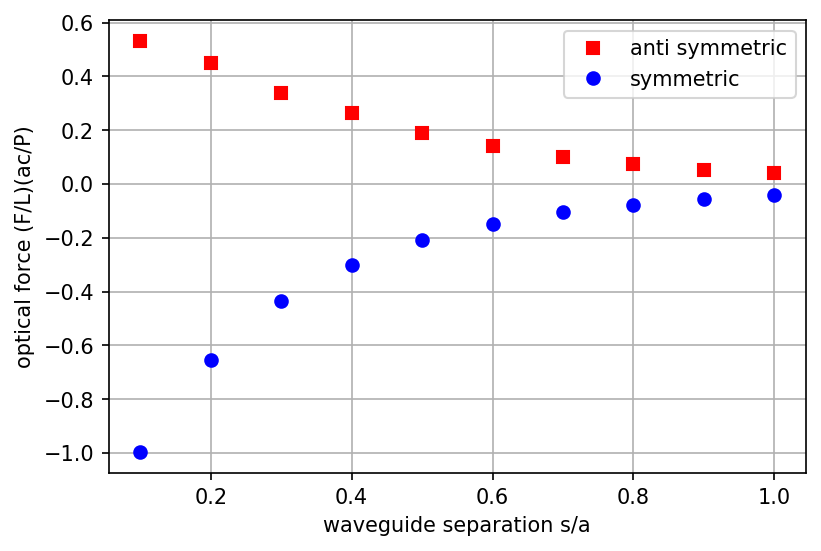

In [3]:
plt.figure(dpi=150)
plt.plot(s,-forces_odd/fluxes_odd,'rs',label='anti symmetric')
plt.plot(s,-forces_even/fluxes_even,'bo',label='symmetric')
plt.grid(True)
plt.xlabel('waveguide separation s/a')
plt.ylabel('optical force (F/L)(ac/P)')
plt.legend(loc='upper right')
plt.show()

The MPB simulation is below. Note: since MPB permits symmetries only in the $y$ and $z$ directions, the coordinate axes used in the MPB script to define the waveguide geometry are different than those in the Meep script. In MPB, the propagating axis is $x$ whereas in Meep it is $z$.

In [4]:
import meep as mp
from meep import mpb
import numpy as np
import matplotlib.pyplot as plt

resolution = 128  # pixels/μm

Si = mp.Medium(index=3.45)

syz = 10
geometry_lattice = mp.Lattice(size=mp.Vector3(0,syz,syz))

k_points = [mp.Vector3(0.5)]

num_bands = 1
tolerance = 1e-9

a = 1.0  # waveguide width

def parallel_waveguide(s,yodd):
    geometry = [mp.Block(center=mp.Vector3(0,-0.5*(s+a),0),
                         size=mp.Vector3(mp.inf,a,a),
                         material=Si),
                mp.Block(center=mp.Vector3(0,0.5*(s+a),0),
                         size=mp.Vector3(mp.inf,a,a),
                         material=Si)]

    ms = mpb.ModeSolver(resolution=resolution,
                        k_points=k_points,
                        geometry_lattice=geometry_lattice,
                        geometry=geometry,
                        num_bands=num_bands,
                        tolerance=tolerance)

    if yodd:
        ms.run_yodd_zodd()
    else:
        ms.run_yeven_zodd()

    f = ms.get_freqs()[0]
    vg = ms.compute_group_velocity_component(mp.Vector3(1,0,0))[0]

    return f,vg

ss = np.arange(0.1,1.1,0.1)

f_odd = np.zeros(len(ss))
vg_odd = np.zeros(len(ss))
f_even = np.zeros(len(ss))
vg_even = np.zeros(len(ss))

for j in range(len(ss)):
    f_odd[j], vg_odd[j] = parallel_waveguide(ss[j],True)
    f_even[j], vg_even[j] = parallel_waveguide(ss[j],False)

ds = ss[1]-ss[0]

def compute_force(f,vg):
    f_avg = 0.5*(f[:-1]+f[1:])
    df = f[1:]-f[:-1]
    vg_avg = 0.5*(vg[:-1]+vg[1:])
    return np.multiply(np.multiply(-1/f_avg,df/ds), 1/vg_avg)

force_odd = compute_force(f_odd,vg_odd)
force_even = compute_force(f_even,vg_even)

Initializing eigensolver data
Computing 1 bands with 1e-09 tolerance
Working in 3 dimensions.
Grid size is 1 x 1280 x 1280.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 10, 0)
     (0, 0, 10)
Cell volume = 100
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.1, -0)
     (0, -0, 0.1)
Geometric objects:
     block, center = (0,-0.55,0)
          size (1e+20,1,1)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0.55,0)
          size (1e+20,1,1)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: zoddyodd.
Initializing fields to random numbers...
1 k-points
  Vector3<0.5, 0.0, 0.0>
elapsed time for initialization: 1.1171050071716309
solve_kpoint (0.5,0,0):
Solving for bands 1 to 1...
Finished solving for bands 1 to 1 after 18 iterations.
zoddy

Cell volume = 100
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.1, -0)
     (0, -0, 0.1)
Geometric objects:
     block, center = (0,-0.7,0)
          size (1e+20,1,1)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (0,0.7,0)
          size (1e+20,1,1)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: zoddyeven.
Initializing fields to random numbers...
1 k-points
  Vector3<0.5, 0.0, 0.0>
elapsed time for initialization: 1.2923684120178223
solve_kpoint (0.5,0,0):
Solving for bands 1 to 1...
Finished solving for bands 1 to 1 after 18 iterations.
zoddyevenfreqs:, 1, 0.5, 0, 0, 0.5, 0.222012
elapsed time for k point: 24.478357791900635
total elapsed time for run: 25.771002054214478
done
Initializing eigensolver data
Computing 1 bands with 1e-09 tolerance
Working in 3 dimensions.
Grid size is 1 x 1280 x 1280.


          size (1e+20,1,1)
          axes (1,0,0), (0,1,0), (0,0,1)
Geometric object tree has depth 2 and 6 object nodes (vs. 2 actual objects)
Initializing epsilon function...
Allocating fields...
Solving for band polarization: zoddyodd.
Initializing fields to random numbers...
1 k-points
  Vector3<0.5, 0.0, 0.0>
elapsed time for initialization: 1.3384766578674316
solve_kpoint (0.5,0,0):
Solving for bands 1 to 1...
Finished solving for bands 1 to 1 after 18 iterations.
zoddyoddfreqs:, 1, 0.5, 0, 0, 0.5, 0.226949
elapsed time for k point: 24.747398614883423
total elapsed time for run: 26.086078643798828
done
Initializing eigensolver data
Computing 1 bands with 1e-09 tolerance
Working in 3 dimensions.
Grid size is 1 x 1280 x 1280.
Solving for 1 bands at a time.
Creating Maxwell data...
Mesh size is 3.
Lattice vectors:
     (1, 0, 0)
     (0, 10, 0)
     (0, 0, 10)
Cell volume = 100
Reciprocal lattice vectors (/ 2 pi):
     (1, -0, 0)
     (-0, 0.1, -0)
     (0, -0, 0.1)
Geometric object

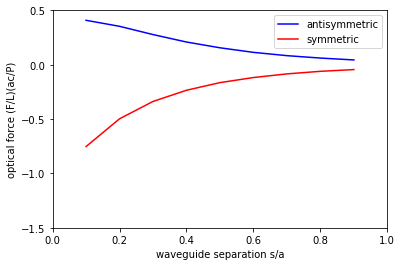

In [5]:
plt.plot(ss[:-1],force_odd,'b-',label='antisymmetric')
plt.plot(ss[:-1],force_even,'r-',label='symmetric')
plt.xlabel("waveguide separation s/a")
plt.ylabel("optical force (F/L)(ac/P)")
plt.legend(loc='upper right')
plt.xticks(np.arange(0,1.2,0.2))
plt.yticks(np.arange(-1.5,1.0,0.5))
plt.show()